# Supresión de errores

En este notebook vamos a ver como aplicar la técnica de desacoplamiento dinámico utilizando Qiskit.

Empezamos construyendo un circuito sobre el que aplicar la técnica. 

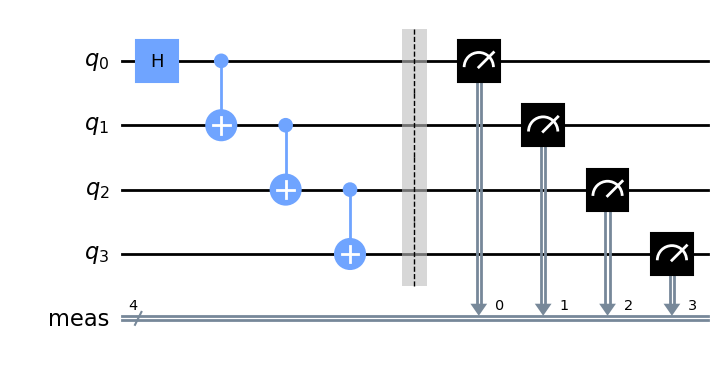

In [1]:
from qiskit import QuantumCircuit

#Construimos un circuito
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()
circ.draw()

Elegimos el backend sobre el que lo vamos a ejecutar y conseguimos la información sobre la duración de sus instrucciones y sus restricciones temporales. Esta información la vamos a necesitar para aplicar el pase de desacoplamiento dinámico. 

In [2]:
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler import InstructionDurations

#Selecciono el backend a utilizar 
provider=IBMProvider()
backend=provider.get_backend("ibm_kyoto")


#Obtengo la duración de sus intrucciones y las restricciones temporales
durations = InstructionDurations.from_backend(backend)
constraints = backend.configuration().timing_constraints


Transpilamos el circuito para descomponerlo en puertas nativas, ya que son las únicas de las que hemos obtenido información sobre su duración y las únicas, por tanto, que vamos a poder planificar. 


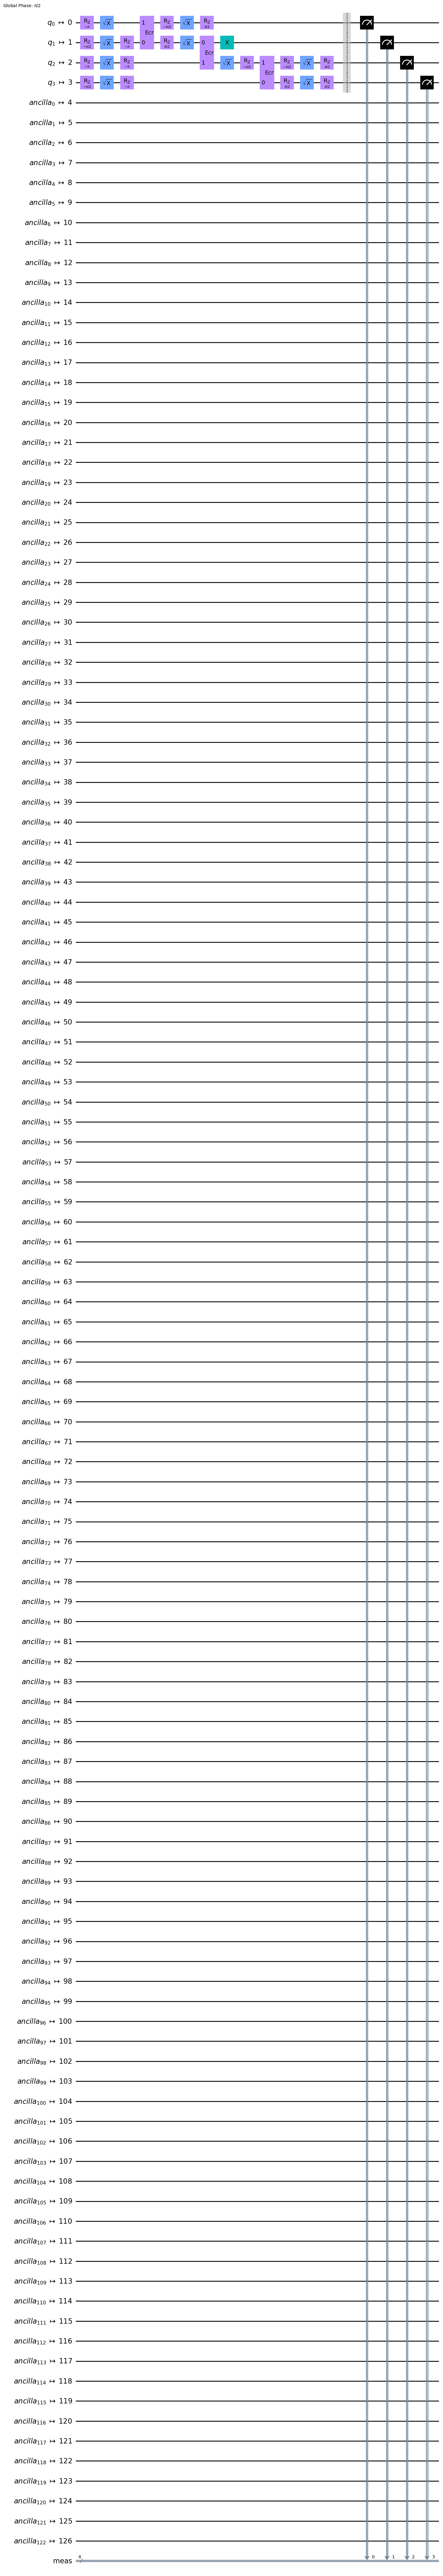

In [3]:
from qiskit import transpile

tcirc=transpile(circ,backend)
tcirc.draw()

In [4]:
#Imprimo algunos valores
print('duracion ecr(1,0)=',durations.get('ecr',[1,0]))
print('duracion ecr(1,2)=',durations.get('ecr',[1,2]))
print('duracion ecr(3,2)=',durations.get('ecr',[3,2]))

duracion ecr(1,0)= 1320
duracion ecr(1,2)= 1320
duracion ecr(3,2)= 1320


Finalmente establecemos la secuencia de acoplamiento, creamos el Pass Manager con los pases de planificación y de desacoplamiento dinámico (el pase de desacoplamiento hay que aplicarlo sobre un circuito que haya sido planificado) y lo ejecutamos sobre el circuito. 

En el pase de planificación tenemos que especificar la duración de las instrucciones y en el pase de desacoplamiento dinámico la duración de las intrucciones, la secuencia de desacoplamiento a aplicar y la restricción de alineamiento de las puertas (pulse_alignment).

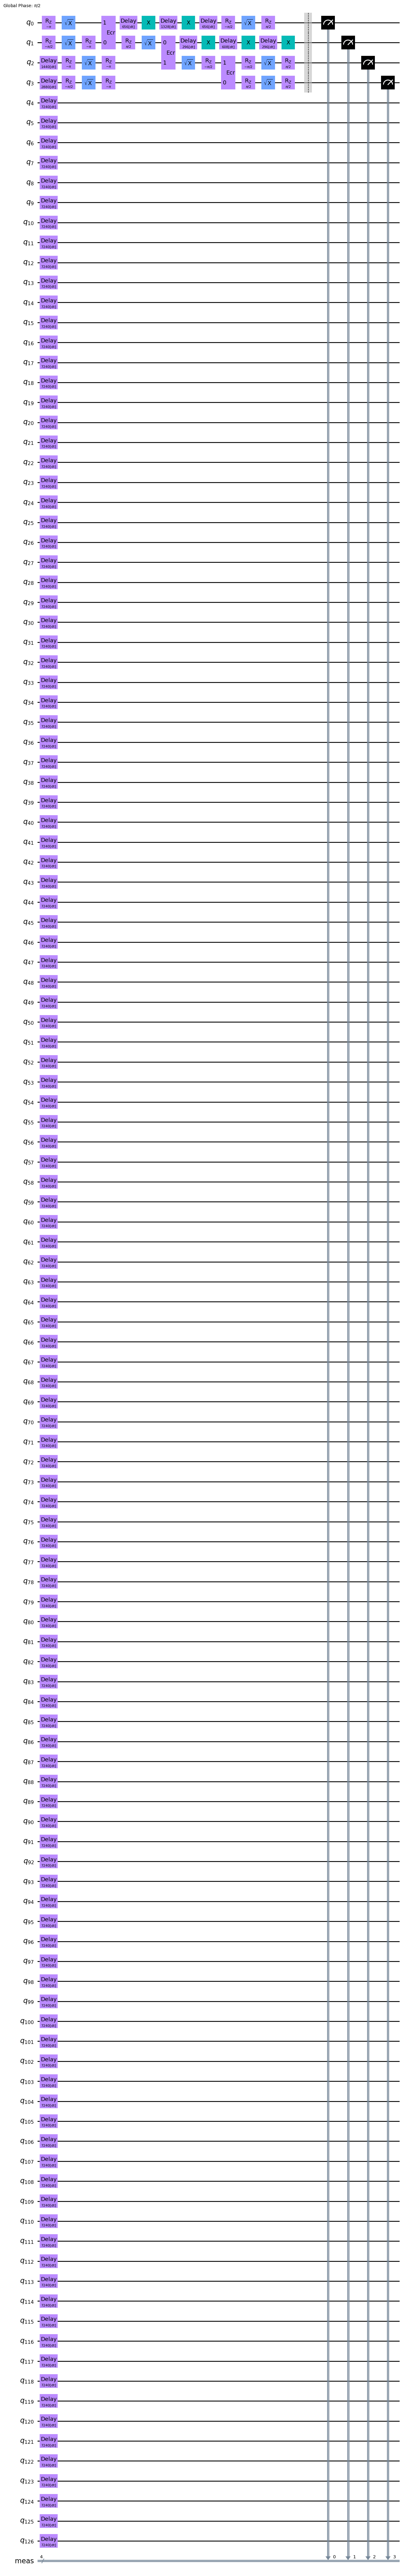

In [5]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling


# Aplico el desacoplamiento dinámico usando una secuencia X-X 
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, pulse_alignment=constraints['pulse_alignment'])])
#Hay que aplicarlo al circuito transpilado
#circ_dd = pm.run(circ)
circ_dd = pm.run(tcirc)
circ_dd.draw()

Vemos que se han introducido un par de puertas X al final de los qubits q0 y q1. Estas puertas se ejecutarán mientras se está ejecutando el resto de puertas de los qubits 2 y 3. De esta forma se evita que los qubits q0 y q1 decaigan su valor antes de la medida.  

Vamos ahora a ejecutar los circuitos con y sin supresion de errores y comparar sus salidas

In [6]:
job=backend.run(tcirc)
job_dd=backend.run(circ_dd)

In [8]:
result=job.result()
counts=result.get_counts()
result_dd=job_dd.result()
counts_dd=result_dd.get_counts()

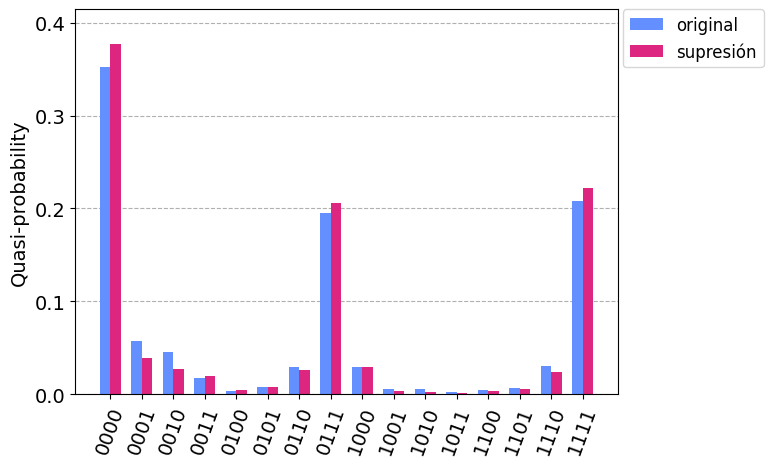

In [13]:
from qiskit.visualization import plot_distribution
plot_distribution([counts, counts_dd], legend=['original','supresión'], bar_labels=False)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table